In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [99]:
from sklearn.cluster import KMeans

def split_by_kmeans(cnt, binary, k=2):
    # 1. 创建轮廓区域 mask
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    # 2. 获取 mask 内部所有像素点坐标 (y,x)
    ys, xs = np.where(mask == 255)
    coords = np.column_stack((xs, ys))

    # 3. 如果点太少或太密，跳过
    if len(coords) < 50:
        return [cnt]

    # 4. KMeans 聚类
    kmeans = KMeans(n_clusters=k, n_init=10).fit(coords)
    labels = kmeans.labels_

    # 5. 按聚类结果生成mask
    split_contours = []
    for i in range(k):
        cluster_mask = np.zeros_like(binary)
        cluster_points = coords[labels == i]
        for x, y in cluster_points:
            cluster_mask[y, x] = 255
        cluster_mask = cv2.morphologyEx(cluster_mask, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8))
        # 提取轮廓
        contours, _ = cv2.findContours(cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        split_contours.extend(contours)

    return split_contours

def is_overlapping(cnt, solidity_thresh=0.8, defect_thresh=2):
    area = cv2.contourArea(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 1.0

    # hull_indices = cv2.convexHull(cnt, returnPoints=False)
    # defects = cv2.convexityDefects(cnt, hull_indices)
    # num_defects = len(defects) if defects is not None else 0
    print(area, solidity)
    return solidity < solidity_thresh #or num_defects >= defect_thresh


def cut_by_deepest_defects(cnt, binary, top_k=2, depth_thresh=1000):
    hull = cv2.convexHull(cnt, returnPoints=False)
    defects = cv2.convexityDefects(cnt, hull)

    # 创建当前轮廓的 mask
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    if defects is not None and len(defects) >= top_k:
        # 提取所有凹陷点和深度
        far_points = []
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            if d > depth_thresh:
                far = tuple(cnt[f][0])
                far_points.append((far, d))

        # 如果足够多凹陷点，则选择最深的两个
        if len(far_points) >= 2:
            far_points = sorted(far_points, key=lambda x: -x[1])[:top_k]
            pt1, pt2 = far_points[0][0], far_points[1][0]
            cv2.line(mask, pt1, pt2, 0, 2)

    return mask


21.0 0.8936170212765957
;a;
0.0 1.0
146.5 0.8772455089820359
;a;
67.0 0.6733668341708543
;a;
14.0 0.8235294117647058
;a;
268.5 0.9040404040404041
340.0 0.9327846364883402
872.5 0.8839918946301925
;a;
178.5 0.946949602122016
858.0 0.9608062709966405
166.0 0.8853333333333333
;a;
429.0 0.9618834080717489
97.5 0.8904109589041096
;a;
231.0 0.9525773195876288
499.0 0.9257884972170687
0.0 1.0
915.5 0.9019704433497537
325.5 0.9587628865979382
279.0 0.9473684210526315
249.5 0.9596153846153846
688.5 0.9582463465553236
630.5 0.953857791225416
240.5 0.9024390243902439
2.5 0.625
;a;
371.0 0.9648894668400521
3694.0 0.9482736490822744
293.5 0.8907435508345979
;a;
2.5 0.8333333333333334
;a;
1634.0 0.9169472502805837
137.5 0.9259259259259259
0.0 1.0
0.0 1.0
143.0 0.9285714285714286
881.0 0.9347480106100796
279.5 0.9588336192109777
433.0 0.9547960308710033
212.5 0.9299781181619255
174.0 0.928
254.5 0.8992932862190812
;a;
0.0 1.0
87.0 0.7945205479452054
;a;
353.0 0.930171277997365
391.5 0.825949367088607

(-0.5, 1135.5, 499.5, -0.5)

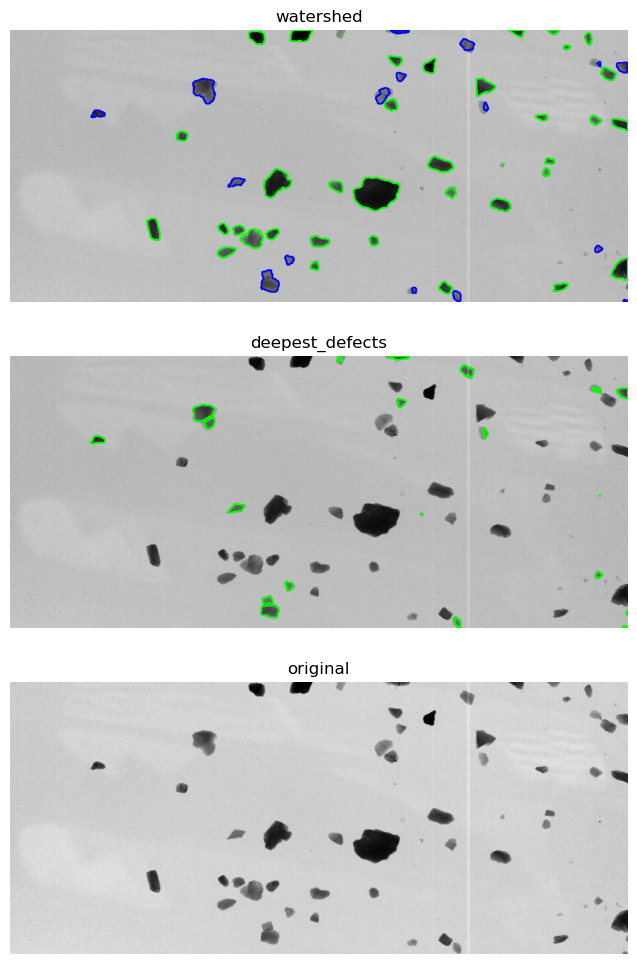

In [114]:
# img = cv2.imread("1749001387562020400.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]
img = cv2.imread("1749114607646606900.png", cv2.IMREAD_GRAYSCALE)[:, 200:1336]

_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 构造新分割 mask
final_mask_v2 = np.zeros_like(binary)

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

normal_contours = []
split_contours = []

error_contours = []

for cnt in contours:
    if is_overlapping(cnt, solidity_thresh=0.9):
        print(';a;')
        # 构造局部mask
        mask = np.zeros_like(binary)
        cv2.drawContours(mask, [cnt], -1, 255, -1)

        # 在mask区域中做分水岭
        roi = cv2.bitwise_and(binary, binary, mask=mask)
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.8 * dist_transform.max(), 255, 0)

        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        _, markers = cv2.connectedComponents(sure_fg)
        markers += 1
        markers[unknown == 255] = 0

        # Watershed 分割
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        markers = cv2.watershed(img_color, markers)

        for mark in np.unique(markers):
            if mark <= 1:
                continue
            mask2 = np.uint8(markers == mark)
            contours_ws, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            split_contours.extend(contours_ws)

        # 选择每个轮廓中最深的两个凹陷点，并连线切割
        try:
            cut_mask = cut_by_deepest_defects(cnt, binary)
            final_mask_v2 = cv2.bitwise_or(final_mask_v2, cut_mask)
        except:
            error_contours.append(cnt)

    # if is_overlapping(cnt):
    #     # 用聚类算法替代分水岭
    #     sub_contours = split_by_kmeans(cnt, binary, k=2)  # 也可以自动调k
    #     split_contours.extend(sub_contours)
    else:
        normal_contours.append(cnt)


all_contours = normal_contours + split_contours

result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result, normal_contours, -1, (0, 255, 0), 2)
cv2.drawContours(result, split_contours, -1, (0, 0, 255), 2)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].imshow(result)
axes[0].set_title("watershed")
axes[0].axis('off')

# for cnt in contours:
#     area = cv2.contourArea(cnt)
#     if area > 1000:
#         cut_mask = cut_by_deepest_defects(cnt, binary)
#         final_mask_v2 = cv2.bitwise_or(final_mask_v2, cut_mask)

# 提取新轮廓
contours_v2, _ = cv2.findContours(final_mask_v2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 绘制结果
output_v2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for i, cnt in enumerate(contours_v2):
    cv2.drawContours(output_v2, [cnt], -1, (0, 255, 0), 2)
    # M = cv2.moments(cnt)
    # if M["m00"] != 0:
    #     cx = int(M["m10"] / M["m00"])
    #     cy = int(M["m01"] / M["m00"])
    #     cv2.putText(output_v2, f"{i+1}", (cx - 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# 显示新结果
axes[1].imshow(cv2.cvtColor(output_v2, cv2.COLOR_BGR2RGB))
axes[1].set_title("deepest_defects")
axes[1].axis('off')

axes[2].imshow(img, cmap = 'gray')
axes[2].set_title("original")
axes[2].axis('off')



In [106]:
len(error_contours)

2

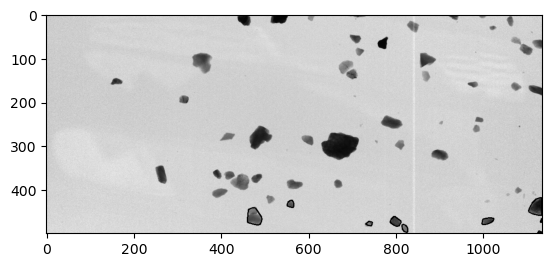

In [94]:
test = img.copy()
for cntt in contours[0:10]:
    hull = cv2.convexHull(cntt)
    # 绘制凸包
    cv2.drawContours(test, [hull], 0, (0,255,0), 2)
    plt.imshow(test, cmap='gray')

In [57]:
hull = cv2.convexHull(contours[2], returnPoints=False)
defects = cv2.convexityDefects(contours[2], hull)

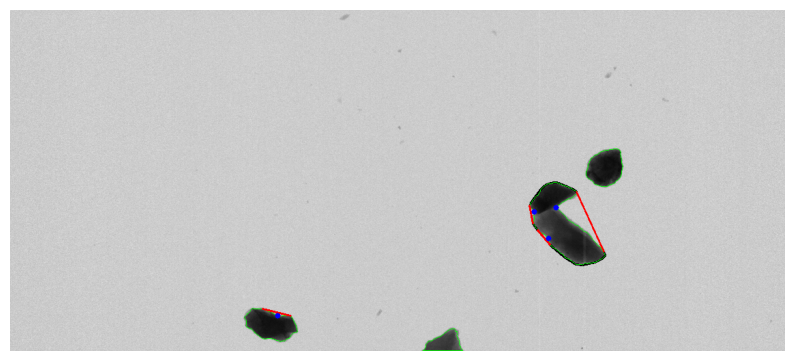

In [69]:
# 创建绘图底图
result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

def draw_defect_lines(cnt, img_draw):
    hull = cv2.convexHull(cnt, returnPoints=False)
    defects = cv2.convexityDefects(cnt, hull)
    if defects is not None:
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
            if d > 1000:  # 深度阈值过滤
                cv2.line(img_draw, start, end, (0, 0, 255), 2)
                cv2.circle(img_draw, far, 4, (255, 0, 0), -1)

# 遍历所有轮廓，分析并绘制凹陷切割线
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 1000:
        cv2.drawContours(result, [cnt], -1, (0, 255, 0), 1)
        draw_defect_lines(cnt, result)

# 显示结果
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.title("轮廓及凹陷分割线演示")
plt.axis('off')
plt.show()
